In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

Using TensorFlow backend.


In [22]:
data_train = pd.read_csv('air_quality_train.csv')
data_test = pd.read_csv('air_quality_test.csv')

In [23]:
data_train.drop('Unnamed: 0', axis=1, inplace=True)
data_test.drop('Unnamed: 0', axis=1, inplace=True)

In [24]:
def series_to_supervised(data, in_lag=1, out_lag=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(in_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, out_lag):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    new_df = pd.concat(cols, axis=1)
    new_df.columns = names
    
    if dropnan:
        new_df.dropna(inplace=True)
    return new_df

# lag = 1

In [25]:
data_train_framed = series_to_supervised(data_train)

In [26]:
data_train_framed.drop(data_train_framed.columns[[12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)

In [27]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t)']]

In [28]:
data_test_framed = series_to_supervised(data_test)

In [29]:
data_test_framed.drop(data_test_framed.columns[[12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)

In [72]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y_validation = data_test_framed.loc[:,['var12(t)']]

In [31]:
def split_data(x, y, train_size):
    x_train = x[:int(len(x)*train_size)]
    x_test = x[int(len(x)*train_size):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[int(len(y)*train_size):]
    
    return x_train, x_test, y_train, y_test

In [32]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [33]:
x = np.expand_dims(x, axis=2)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [73]:
x_validation = np.expand_dims(x_validation, axis=2)

In [34]:
print(x.shape, x_train.shape, x_test.shape, x_validation.shape)

(7483, 12, 1) (5986, 12, 1) (1497, 12, 1) (1871, 12, 1)


In [35]:
stop_noimprovement = EarlyStopping(patience=10)

model = Sequential()

model.add(LSTM(50, input_shape=(12, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")

W0705 13:51:08.981528 140183222208320 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 13:51:08.999275 140183222208320 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 13:51:09.002636 140183222208320 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 13:51:09.409682 140183222208320 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

# Test and validation with 100 epochs

In [36]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

W0705 13:51:40.040226 140183222208320 deprecation.py:323] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0705 13:51:40.559030 140183222208320 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5986 samples, validate on 1497 samples
Epoch 1/100
 - 4s - loss: 0.1359 - val_loss: 0.2013
Epoch 2/100
 - 2s - loss: 0.1205 - val_loss: 0.2175
Epoch 3/100
 - 2s - loss: 0.1127 - val_loss: 0.2352
Epoch 4/100
 - 2s - loss: 0.1068 - val_loss: 0.1865
Epoch 5/100
 - 2s - loss: 0.0998 - val_loss: 0.1838
Epoch 6/100
 - 2s - loss: 0.0962 - val_loss: 0.1575
Epoch 7/100
 - 1s - loss: 0.0894 - val_loss: 0.1351
Epoch 8/100
 - 2s - loss: 0.0815 - val_loss: 0.1104
Epoch 9/100
 - 2s - loss: 0.0729 - val_loss: 0.0905
Epoch 10/100
 - 2s - loss: 0.0668 - val_loss: 0.0787
Epoch 11/100
 - 2s - loss: 0.0604 - val_loss: 0.0688
Epoch 12/100
 - 1s - loss: 0.0536 - val_loss: 0.0647
Epoch 13/100
 - 2s - loss: 0.0470 - val_loss: 0.0696
Epoch 14/100
 - 2s - loss: 0.0422 - val_loss: 0.0675
Epoch 15/100
 - 2s - loss: 0.0406 - val_loss: 0.0636
Epoch 16/100
 - 1s - loss: 0.0389 - val_loss: 0.0668
Epoch 17/100
 - 2s - loss: 0.0394 - val_loss: 0.0637
Epoch 18/100
 - 2s - loss: 0.0385 - val_loss: 0.0658
Epoch 1

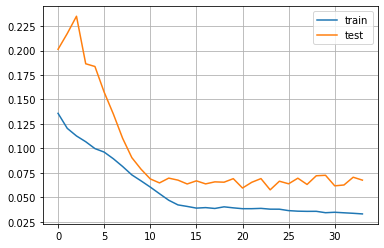

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
prediction = model.predict(x_test)

In [39]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07497


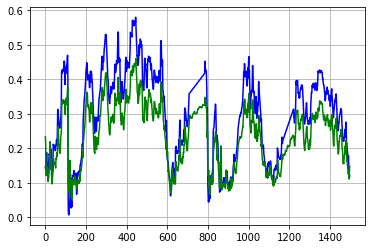

In [40]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [41]:
validation = model.predict(x_validation)

In [42]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06229


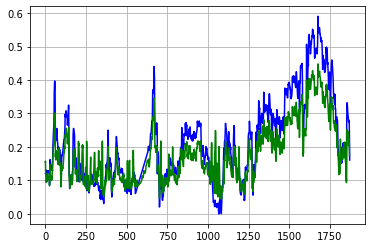

In [43]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 500 epochs

In [44]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5986 samples, validate on 1497 samples
Epoch 1/500
 - 2s - loss: 0.0330 - val_loss: 0.0687
Epoch 2/500
 - 2s - loss: 0.0334 - val_loss: 0.0636
Epoch 3/500
 - 2s - loss: 0.0311 - val_loss: 0.0674
Epoch 4/500
 - 2s - loss: 0.0320 - val_loss: 0.0622
Epoch 5/500
 - 2s - loss: 0.0317 - val_loss: 0.0607
Epoch 6/500
 - 1s - loss: 0.0320 - val_loss: 0.0627
Epoch 7/500
 - 1s - loss: 0.0317 - val_loss: 0.0560
Epoch 8/500
 - 2s - loss: 0.0298 - val_loss: 0.0603
Epoch 9/500
 - 1s - loss: 0.0294 - val_loss: 0.0631
Epoch 10/500
 - 1s - loss: 0.0297 - val_loss: 0.0648
Epoch 11/500
 - 1s - loss: 0.0286 - val_loss: 0.0610
Epoch 12/500
 - 1s - loss: 0.0279 - val_loss: 0.0612
Epoch 13/500
 - 1s - loss: 0.0279 - val_loss: 0.0604
Epoch 14/500
 - 1s - loss: 0.0268 - val_loss: 0.0538
Epoch 15/500
 - 1s - loss: 0.0265 - val_loss: 0.0682
Epoch 16/500
 - 2s - loss: 0.0261 - val_loss: 0.0600
Epoch 17/500
 - 2s - loss: 0.0254 - val_loss: 0.0585
Epoch 18/500
 - 2s - loss: 0.0246 - val_loss: 0.0625
Epoch 1

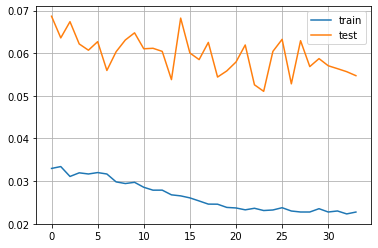

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
prediction = model.predict(x_test)

In [47]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.06159


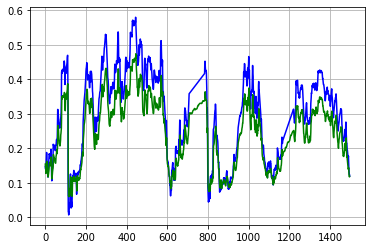

In [48]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [49]:
validation = model.predict(x_validation)

In [50]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.04657


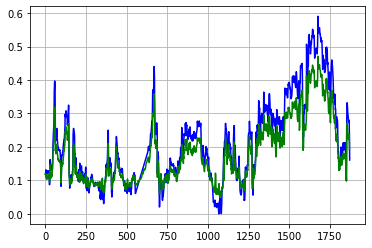

In [51]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 1000 epochs

In [52]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5986 samples, validate on 1497 samples
Epoch 1/1000
 - 2s - loss: 0.0228 - val_loss: 0.0573
Epoch 2/1000
 - 2s - loss: 0.0229 - val_loss: 0.0607
Epoch 3/1000
 - 2s - loss: 0.0224 - val_loss: 0.0577
Epoch 4/1000
 - 2s - loss: 0.0226 - val_loss: 0.0535
Epoch 5/1000
 - 2s - loss: 0.0224 - val_loss: 0.0615
Epoch 6/1000
 - 1s - loss: 0.0227 - val_loss: 0.0515
Epoch 7/1000
 - 2s - loss: 0.0228 - val_loss: 0.0611
Epoch 8/1000
 - 2s - loss: 0.0221 - val_loss: 0.0576
Epoch 9/1000
 - 2s - loss: 0.0231 - val_loss: 0.0587
Epoch 10/1000
 - 2s - loss: 0.0220 - val_loss: 0.0658
Epoch 11/1000
 - 2s - loss: 0.0220 - val_loss: 0.0579
Epoch 12/1000
 - 2s - loss: 0.0223 - val_loss: 0.0550
Epoch 13/1000
 - 2s - loss: 0.0220 - val_loss: 0.0612
Epoch 14/1000
 - 1s - loss: 0.0222 - val_loss: 0.0515
Epoch 15/1000
 - 2s - loss: 0.0222 - val_loss: 0.0504
Epoch 16/1000
 - 1s - loss: 0.0223 - val_loss: 0.0479
Epoch 17/1000
 - 2s - loss: 0.0223 - val_loss: 0.0532
Epoch 18/1000
 - 1s - loss: 0.0228 - val_lo

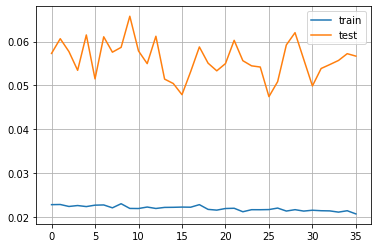

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
prediction = model.predict(x_test)

In [55]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.06368


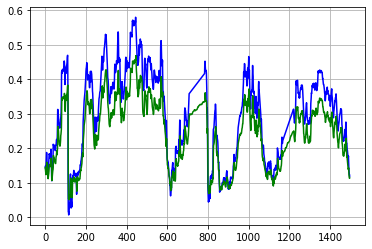

In [56]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [57]:
validation = model.predict(x_validation)

In [58]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.04768


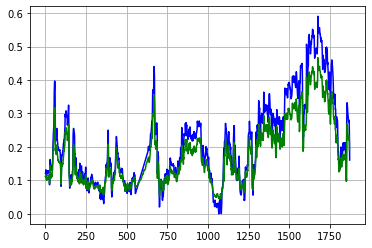

In [59]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# lag = 5

In [60]:
data_train_framed = series_to_supervised(data_train, out_lag=5)

In [61]:
data_train_framed.drop(data_train_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
]], axis=1, inplace=True)

In [62]:
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+4)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.293261
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.281288
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.286126
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.283487
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.277085


In [63]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t+4)']]

In [64]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [65]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# Test and validation with 100 epochs

In [66]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5983 samples, validate on 1496 samples
Epoch 1/100
 - 2s - loss: 0.0501 - val_loss: 0.0619
Epoch 2/100
 - 2s - loss: 0.0498 - val_loss: 0.0640
Epoch 3/100
 - 2s - loss: 0.0494 - val_loss: 0.0629
Epoch 4/100
 - 2s - loss: 0.0491 - val_loss: 0.0646
Epoch 5/100
 - 1s - loss: 0.0491 - val_loss: 0.0638
Epoch 6/100
 - 2s - loss: 0.0487 - val_loss: 0.0683
Epoch 7/100
 - 2s - loss: 0.0491 - val_loss: 0.0661
Epoch 8/100
 - 2s - loss: 0.0490 - val_loss: 0.0647
Epoch 9/100
 - 2s - loss: 0.0495 - val_loss: 0.0667
Epoch 10/100
 - 1s - loss: 0.0495 - val_loss: 0.0639
Epoch 11/100
 - 2s - loss: 0.0489 - val_loss: 0.0676


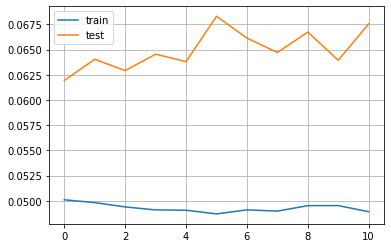

In [67]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
prediction = model.predict(x_test)

In [69]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07981


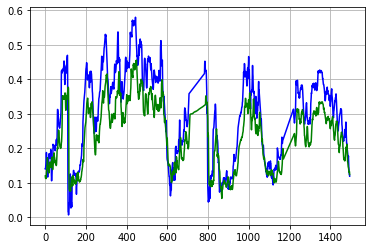

In [70]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [74]:
validation = model.predict(x_validation)

In [75]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05038


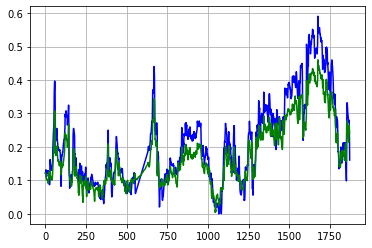

In [76]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 500 epochs

In [77]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5983 samples, validate on 1496 samples
Epoch 1/500
 - 2s - loss: 0.0489 - val_loss: 0.0665
Epoch 2/500
 - 2s - loss: 0.0494 - val_loss: 0.0678
Epoch 3/500
 - 2s - loss: 0.0489 - val_loss: 0.0670
Epoch 4/500
 - 2s - loss: 0.0492 - val_loss: 0.0663
Epoch 5/500
 - 2s - loss: 0.0486 - val_loss: 0.0668
Epoch 6/500
 - 2s - loss: 0.0486 - val_loss: 0.0675
Epoch 7/500
 - 2s - loss: 0.0485 - val_loss: 0.0684
Epoch 8/500
 - 2s - loss: 0.0483 - val_loss: 0.0660
Epoch 9/500
 - 2s - loss: 0.0482 - val_loss: 0.0673
Epoch 10/500
 - 2s - loss: 0.0485 - val_loss: 0.0660
Epoch 11/500
 - 2s - loss: 0.0489 - val_loss: 0.0675
Epoch 12/500
 - 2s - loss: 0.0487 - val_loss: 0.0626
Epoch 13/500
 - 2s - loss: 0.0485 - val_loss: 0.0676
Epoch 14/500
 - 2s - loss: 0.0489 - val_loss: 0.0652
Epoch 15/500
 - 2s - loss: 0.0481 - val_loss: 0.0673
Epoch 16/500
 - 2s - loss: 0.0484 - val_loss: 0.0643
Epoch 17/500
 - 1s - loss: 0.0481 - val_loss: 0.0652
Epoch 18/500
 - 2s - loss: 0.0485 - val_loss: 0.0602
Epoch 1

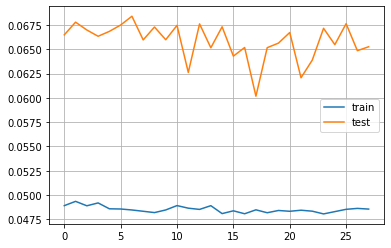

In [78]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
prediction = model.predict(x_test)

In [80]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07797


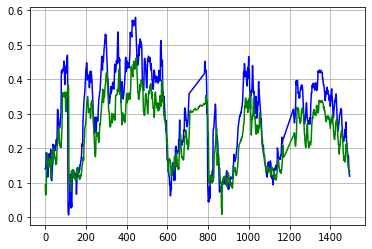

In [81]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [82]:
validation = model.predict(x_validation)

In [83]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05055


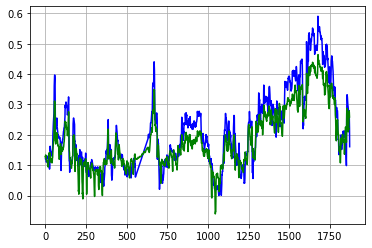

In [84]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 1000 epochs

In [85]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5983 samples, validate on 1496 samples
Epoch 1/1000
 - 2s - loss: 0.0482 - val_loss: 0.0636
Epoch 2/1000
 - 2s - loss: 0.0484 - val_loss: 0.0621
Epoch 3/1000
 - 2s - loss: 0.0480 - val_loss: 0.0661
Epoch 4/1000
 - 2s - loss: 0.0487 - val_loss: 0.0648
Epoch 5/1000
 - 2s - loss: 0.0481 - val_loss: 0.0640
Epoch 6/1000
 - 2s - loss: 0.0479 - val_loss: 0.0651
Epoch 7/1000
 - 2s - loss: 0.0479 - val_loss: 0.0659
Epoch 8/1000
 - 2s - loss: 0.0484 - val_loss: 0.0654
Epoch 9/1000
 - 2s - loss: 0.0478 - val_loss: 0.0626
Epoch 10/1000
 - 2s - loss: 0.0481 - val_loss: 0.0667
Epoch 11/1000
 - 2s - loss: 0.0485 - val_loss: 0.0623
Epoch 12/1000
 - 2s - loss: 0.0482 - val_loss: 0.0608
Epoch 13/1000
 - 2s - loss: 0.0483 - val_loss: 0.0623
Epoch 14/1000
 - 1s - loss: 0.0484 - val_loss: 0.0649
Epoch 15/1000
 - 2s - loss: 0.0476 - val_loss: 0.0617
Epoch 16/1000
 - 2s - loss: 0.0476 - val_loss: 0.0618
Epoch 17/1000
 - 2s - loss: 0.0478 - val_loss: 0.0589
Epoch 18/1000
 - 2s - loss: 0.0477 - val_lo

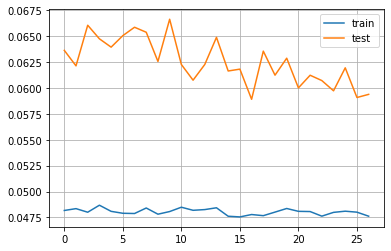

In [86]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
prediction = model.predict(x_test)

In [88]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07255


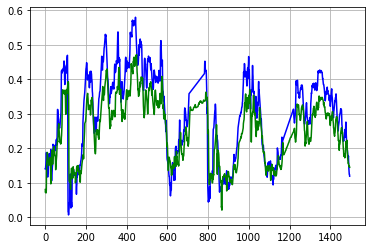

In [89]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [90]:
validation = model.predict(x_validation)

In [91]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.0478


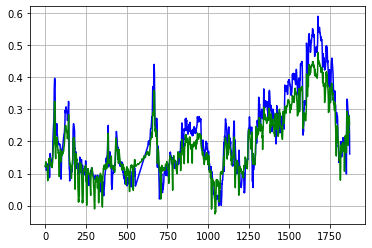

In [92]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# lag = 10

In [93]:
data_train_framed = series_to_supervised(data_train, out_lag=10)

In [94]:
data_train_framed.drop(data_train_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,
    72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,
    92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,
    109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,
    124,125,126,127,128,129,130
]], axis=1, inplace=True)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+9)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.274544
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.269706
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.269071
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.272199
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.271759


In [95]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t+9)']]

In [96]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [97]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# 100 epochs

In [98]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5979 samples, validate on 1495 samples
Epoch 1/100
 - 2s - loss: 0.0609 - val_loss: 0.0634
Epoch 2/100
 - 2s - loss: 0.0616 - val_loss: 0.0632
Epoch 3/100
 - 2s - loss: 0.0608 - val_loss: 0.0638
Epoch 4/100
 - 2s - loss: 0.0607 - val_loss: 0.0630
Epoch 5/100
 - 2s - loss: 0.0608 - val_loss: 0.0647
Epoch 6/100
 - 2s - loss: 0.0611 - val_loss: 0.0623
Epoch 7/100
 - 2s - loss: 0.0606 - val_loss: 0.0614
Epoch 8/100
 - 2s - loss: 0.0606 - val_loss: 0.0612
Epoch 9/100
 - 2s - loss: 0.0606 - val_loss: 0.0631
Epoch 10/100
 - 3s - loss: 0.0604 - val_loss: 0.0616
Epoch 11/100
 - 2s - loss: 0.0606 - val_loss: 0.0635
Epoch 12/100
 - 2s - loss: 0.0606 - val_loss: 0.0615
Epoch 13/100
 - 2s - loss: 0.0604 - val_loss: 0.0639
Epoch 14/100
 - 2s - loss: 0.0605 - val_loss: 0.0628
Epoch 15/100
 - 2s - loss: 0.0607 - val_loss: 0.0619
Epoch 16/100
 - 2s - loss: 0.0604 - val_loss: 0.0624
Epoch 17/100
 - 2s - loss: 0.0604 - val_loss: 0.0634
Epoch 18/100
 - 2s - loss: 0.0606 - val_loss: 0.0637


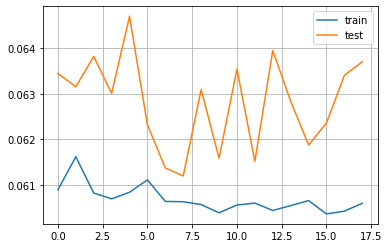

In [99]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
prediction = model.predict(x_test)

In [101]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.08287


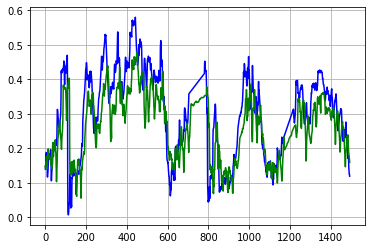

In [102]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [103]:
validation = model.predict(x_validation)

In [104]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.0493


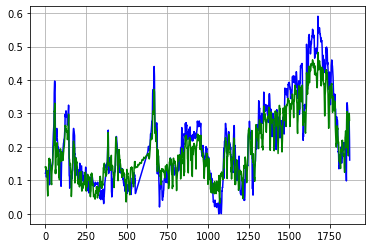

In [105]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 500 epochs

In [106]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5979 samples, validate on 1495 samples
Epoch 1/500
 - 2s - loss: 0.0610 - val_loss: 0.0630
Epoch 2/500
 - 2s - loss: 0.0603 - val_loss: 0.0641
Epoch 3/500
 - 2s - loss: 0.0604 - val_loss: 0.0632
Epoch 4/500
 - 2s - loss: 0.0605 - val_loss: 0.0644
Epoch 5/500
 - 2s - loss: 0.0603 - val_loss: 0.0628
Epoch 6/500
 - 2s - loss: 0.0602 - val_loss: 0.0637
Epoch 7/500
 - 1s - loss: 0.0599 - val_loss: 0.0640
Epoch 8/500
 - 2s - loss: 0.0604 - val_loss: 0.0639
Epoch 9/500
 - 2s - loss: 0.0600 - val_loss: 0.0648
Epoch 10/500
 - 2s - loss: 0.0602 - val_loss: 0.0633
Epoch 11/500
 - 2s - loss: 0.0603 - val_loss: 0.0647
Epoch 12/500
 - 2s - loss: 0.0599 - val_loss: 0.0652
Epoch 13/500
 - 2s - loss: 0.0598 - val_loss: 0.0643
Epoch 14/500
 - 2s - loss: 0.0600 - val_loss: 0.0625
Epoch 15/500
 - 1s - loss: 0.0601 - val_loss: 0.0631
Epoch 16/500
 - 2s - loss: 0.0606 - val_loss: 0.0637
Epoch 17/500
 - 2s - loss: 0.0601 - val_loss: 0.0652
Epoch 18/500
 - 2s - loss: 0.0603 - val_loss: 0.0653
Epoch 1

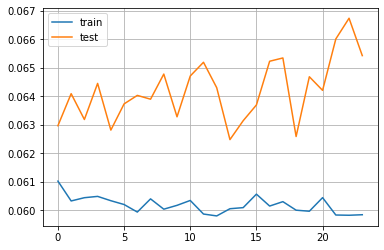

In [107]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
prediction = model.predict(x_test)

In [109]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.08459


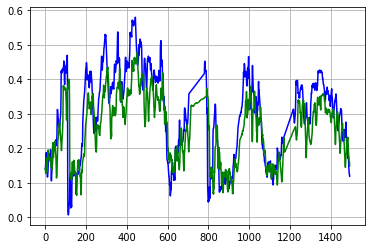

In [110]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [111]:
validation = model.predict(x_validation)

In [112]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.04919


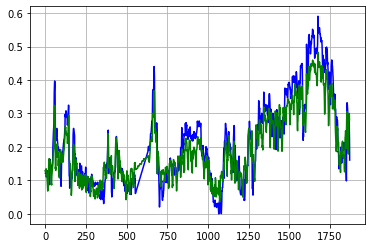

In [113]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 1000 epochs

In [114]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5979 samples, validate on 1495 samples
Epoch 1/1000
 - 2s - loss: 0.0601 - val_loss: 0.0659
Epoch 2/1000
 - 2s - loss: 0.0601 - val_loss: 0.0643
Epoch 3/1000
 - 2s - loss: 0.0600 - val_loss: 0.0651
Epoch 4/1000
 - 2s - loss: 0.0596 - val_loss: 0.0640
Epoch 5/1000
 - 2s - loss: 0.0601 - val_loss: 0.0629
Epoch 6/1000
 - 2s - loss: 0.0602 - val_loss: 0.0635
Epoch 7/1000
 - 2s - loss: 0.0600 - val_loss: 0.0637
Epoch 8/1000
 - 2s - loss: 0.0596 - val_loss: 0.0655
Epoch 9/1000
 - 2s - loss: 0.0598 - val_loss: 0.0641
Epoch 10/1000
 - 2s - loss: 0.0598 - val_loss: 0.0666
Epoch 11/1000
 - 2s - loss: 0.0599 - val_loss: 0.0649
Epoch 12/1000
 - 2s - loss: 0.0600 - val_loss: 0.0638
Epoch 13/1000
 - 2s - loss: 0.0599 - val_loss: 0.0663
Epoch 14/1000
 - 2s - loss: 0.0597 - val_loss: 0.0660
Epoch 15/1000
 - 2s - loss: 0.0599 - val_loss: 0.0638


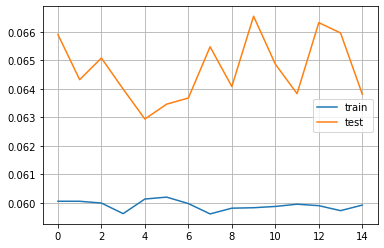

In [115]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [117]:
prediction = model.predict(x_test)

In [118]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.08287


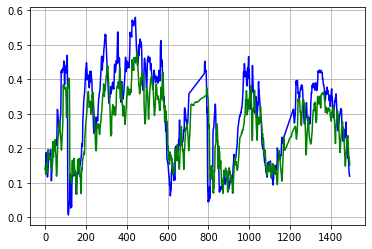

In [119]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [120]:
validation = model.predict(x_validation)

In [121]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.04805


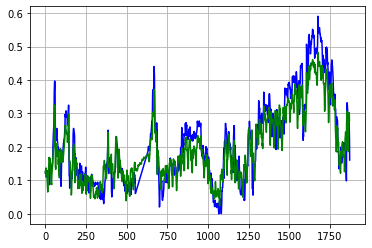

In [122]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)